<a href="https://colab.research.google.com/github/SANGDONKIM/pytorch_d2l/blob/main/GCN_semi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
 

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_scatter-latest%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_sparse-latest%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
  Found existing installation: torch-sparse 0.6.1
    Uninstalling torch-sparse-0.6.1:
      Successfully uninstalled torch-sparse-0.6.1


In [ ]:
G = nx.Graph(name='G')
G


In [ ]:
#Create nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(6):
    G.add_node(i, name=i)

In [ ]:
#Define the edges and the edges to the graph
edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

In [ ]:
#See graph info
print('Graph Info:\n', nx.info(G))

Graph Info:
 Name: G
Type: Graph
Number of nodes: 6
Number of edges: 7
Average degree:   2.3333


In [ ]:
#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())


Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


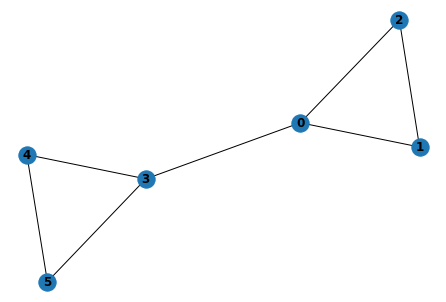

In [ ]:
#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [ ]:
#Adjacency Matrix (A) 
nx.attr_matrix(G, node_attr='name')[0] # adjacency matrix만 출력. matrix type 
A = np.array(nx.attr_matrix(G, node_attr='name')[0]) # Numpy array로 변경 
A

array([[0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0.]])

In [ ]:
nx.attr_matrix(G, node_attr='name')[1] # node feature [0, 1, 2, 3, 4, 5]
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X.shape # (6, )

(6,)

In [ ]:
np.expand_dims(X,axis=1).shape # (6, 1)
np.expand_dims(X,axis=0).shape # (1, 6)

(1, 6)

In [ ]:
X = np.expand_dims(X,axis=1)

In [ ]:
print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)


In [ ]:
#Dot product Adjacency Matrix (A) and Node Features (X)
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


In [ ]:
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()): # G.number_of_nodes() : 노드의 수 = 6
    self_loops.append((i,i))

self_loops

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

In [ ]:
G_self_loops.add_edges_from(self_loops)
#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges) # (0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5) 여기서 self loop 추가 

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]


In [ ]:
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]


In [ ]:
AX = np.dot(A_hat, X)
print(AX.shape)
print('AX:\n', AX)

(6, 1)
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


In [ ]:
#Get the Degree Matrix of the added self-loops graph
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]


In [ ]:
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)
D.shape # (6, 6)

(6, 6)

In [ ]:
for (n,deg) in list(Deg_Mat):
  print(deg)

np.diag([5, 4, 4, 5, 4, 4])
np.diag([5, 4, 4, 5, 4, 4]).shape # (6, 6)
  

5
4
4
5
4
4


(6, 6)

In [ ]:
#Find the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D) # 역행렬 계산 
print('Inverse of D:\n', D_inv)

Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]


In [ ]:
#Dot product of D and AX for normalization
DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)

DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


In [ ]:
#Symmetrically-normalization
D_half_norm = fractional_matrix_power(D, -0.5) # D^-1/2 
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


In [ ]:
#Initialize the weights
np.random.seed(77777)
n_h = 4 #number of neurons in the hidden layer
n_y = 2 #number of neurons in the output layer
W0 = np.random.randn(X.shape[1],n_h) * 0.01 # (1, 4) 차원 normal dist에서 random number 생성 
W1 = np.random.randn(n_h,n_y) * 0.01 # (4, 2) 



In [ ]:
#Implement ReLu as activation function
def relu(x):
    return np.maximum(0,x)

In [ ]:
#Build GCN layer
#In this function, we implement numpy to simplify
def gcn(A,H,W):
    I = np.identity(A.shape[0]) #create Identity Matrix of A
    A_hat = A + I #add self-loop to A
    D = np.diag(np.sum(A_hat, axis=0)) #create Degree Matrix of A
    D_half_norm = fractional_matrix_power(D, -0.5) #calculate D to the power of -0.5
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)

In [ ]:
H1 = gcn(A,X,W0) # A : (6, 6), X : (6, 1), W0 : (1, 4)
H1.shape

(6, 4)

In [ ]:
H2 = gcn(A,H1,W1) # A : (6, 6), X : (6, 4), W0 : (4, 2)
H2.shape
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00027758 0.        ]
 [0.00017298 0.        ]
 [0.00017298 0.        ]
 [0.00053017 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]]


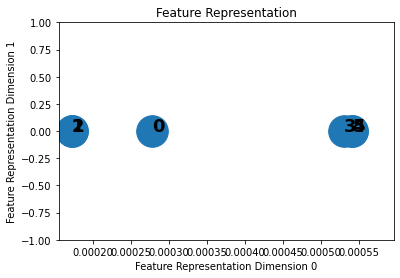

In [ ]:
def plot_features(H2):
    #Plot the features representation
    x = H2[:,0]
    y = H2[:,1]

    size = 1000

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)